# Welcome to the Matrix Inversion numerics lab.

Please refer to the first six chapters of the instructions in the FORTRAN lab manual <a href='http://www.usm.uni-muenchen.de/people/keith/Numprakt/la_manual.pdf'>here</a>. This notebook replaces exercises 1-6 and advanced task 1 of chapter 7. For exercise 7 as well as advanced tasks 2&3, please refer to the FORTRAN lab manual.


In [239]:
#Read in the necessary libraries and packages
import numpy as np
import time
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.linalg import hilbert

#plotting configuration. You may modify this cell, and recompile it, and then remake your plots, and they will
#be updated to match these configurations
almost_black = '#262626'
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams.update({'font.size': 32,
                     'axes.linewidth': 5,
                     'text.color': almost_black,
                     'xtick.major.size': 4,
                     'ytick.major.size': 4,
                     'legend.fancybox': True,
                     'figure.dpi': 300,
                     'legend.fontsize': 16, #the size of the font in the legend
                     'legend.framealpha': 0.8,
                     'legend.scatterpoints': 1,
                     'legend.numpoints': 1,
                     'legend.markerscale': 2,
                     'legend.shadow': False,
                     'xtick.labelsize': 32, #the size of the font on the x-tick labels
                     'ytick.labelsize': 32})

# Exercise 1/2: Gaussian Elimination and LU decomposition

Solve the linear system on a sheet of paper and add it to the report

In this exercise you are given with a system of equations of the form $$\mathbf{A} \vec{x} = \vec{b}$$ that you want to solve for $\vec{x}$. Note that one can easily obtain the inverse of $\mathbf{A}$ if $\vec{b}$ is the identity matrix. In the scipt you have read about the Gaussian elimination algorithm which you are now asked to apply to the system.

During the process, you have converted the equation into 
$$\mathbf{R} \vec{x} = \mathbf{M} \vec{b}$$ where $\mathbf{R}$ is a upper triangular matrix. The system can now be solved in an easy and efficient way. Basically you have decomposed the original matrix $\mathbf{A}$ into two matrices as $$\mathbf{A} = \mathbf{M}^{-1} \mathbf{R}$$ where the matrix $\mathbf{M}$ captures the equivalent transformations you performed during the gaussian elimination algorithm. You have therefore implicitly factorized the original matrix.

Most of the methods used to solve systems of equations, or equivalently invert matrices, are based on this idea of matrix factorization, meaning they decompose the matrix $\mathbf{A} = \mathbf{B} \mathbf{C}$ and solve then for
$$\mathbf{B} \vec{y} = \vec{b} \ \ \text{and} \ \ \mathbf{C} \vec{x} = \vec{y}$$. Of course this assumes that these two equations are easier to solve than the original system. Of course triangular matrices are specifically easy to solve and if we could find a decomposition such that $\mathbf{B}$ is an lower triangular matrix and $\mathbf{C}$ is an upper triangular matrix, we obtain a highly efficient solution scheme. For each square matrix $\mathbf{A}$ there exists a permutation matrix $\mathbf{P}$ and two triangular matrices $\mathbf{L}$ and $\mathbf{U}$ of the form defined in (scipt 19) such that $$\mathbf{P} \mathbf{A} = \mathbf{L} \mathbf{U}$$ is valid. If $\mathbf{A}$ is invertible, then the decomposition of $\mathbf{P}$ is unique. Note that $\mathbf{P} = \mathbf{P}^{-1}$.

The permutation matrix is the result of pivoting which improves the stability of the solution scheme by swapping rows in order to avoid dividing a larger number by a smaller number which is otherwise ill conditioned. As you can see, the LU decomposition is exactly the of the gaussian algorithm with pivoting. In order to accustom yourself with the gaussian algorithm and the LU decomposition we now ask you to manually perform these algorithms carefully taking notes of every step you do. Please write this on a sheet of paper and append it to you solution script.

Your task:
----------
* Manually solve the system of equations:
$$\begin{pmatrix} 2 & 2 & 3 & 1 \\ 3 & 4 & -2 & 5 \\ -5 & 5 & -1 & -2 \\ -1 & -1 & -3 & 3 \end{pmatrix}  \begin{pmatrix} w \\ x \\ y \\ z \end{pmatrix} = \begin{pmatrix} 0 \\ 4 \\ 3 \\ -2 \end{pmatrix}$$
using Gaussian Elimination without using Pivoting.
* Solve the above equation this time using the LU decomposition using partial pivoting.
* Define the variable solution_vec in the following section with your solution. We will use this as a unit test for all following algorithms.

In [240]:
def TEST_INV(fnkt_inv_mat):
    """ Simple routine to test the accuracy of 
    the matrix inversion function my_inv. 
    
    Parameters:
    -----------
    fnkt_inv_mat: function(np.array, RHS_vec), takes a numpy array and 
                  a vector for the right hand side of the linear equation,
                  returns a numpy vector with the solution of the equation
     
    
    Returns:
    --------
    succ_flag: integer, 
               succ_flag is 0 --> test failed
               succ_flag is not 0 --> test succeeded 
    """
    
    #
    #test matrix:
    
    test_matrix = np.array([[2.0, 2.0, 3.0, 1.0], 
                            [3.0, 4.0, -2.0, 5.0],
                            [-5.0, 5.0, -1.0, -2.0],
                            [-1.0, -1.0, -3.0, 3.0]])
    test_vec_RHS = np.array([0.0, 4.0, 3.0, -2.0])
    
    #your result:
    solution_vec = np.array([1,1,-1,-1])
     
    #threshold for numerical accuracy
    num_acc = 1e-6
    
    sol_routine = fnkt_inv_mat(test_matrix, test_vec_RHS)
    print(np.sum(np.abs(solution_vec - sol_routine)))
    if np.sum(np.abs(solution_vec - sol_routine)) > num_acc:
        print('Test failed')
        return 0
    else:
        print('Test successful')
        return 1
    #the routine of assessing a code with known results is called benchmarking

Implementation of the LU decomposition
--------------------------------------
The following section provides an implementation of the LU decomposition method. We use the form of the decomposition to efficiently store the decomposed matrix and the permutation matrix. 
We return the decomposed matrix which has the same form as the original matrix with the upper triangle representing the matrix U and the entries below the triangle representing the matrix L, which has by construction 1's on the diagonal. The permutation matrix is stored in a simple vector as follows
$\vec{z} = \begin{pmatrix} 2 \\ 0 \\ 1 \end{pmatrix} \Leftrightarrow{} \mathbf{P} = \begin{pmatrix} 0 & 0 & 1 \\ 1 & 0 & 0 \\ 0 & 1 & 0 \end{pmatrix}$.
We start from (0,1,2) and we record the switches, we use less computer memory. In addition you can use that vector to permute the b vector.
 In the following sections we want to compare the performance of several pivoting methods which are then passed as a second argument to the LU decomposition method. I already implemented partial pivoting. For detailed explanations of the different pivoting schemes please consult the script.

Your task:
----------
* Use the implementation of the partialPivoting method as a template
* Write the implementation of the implicitPivoting method that implements implicit pivoting 


In [241]:
def noPivoting(mat, col_idx):
    return col_idx, np.abs(mat[col_idx, col_idx])

def partialPivoting(mat, col_idx):#it just finds the maximum but it does not perform the switch
    apivot = np.abs(mat[col_idx, col_idx])
    p = col_idx
    for l in range(col_idx+1, mat.shape[0]):
        if np.abs(mat[l, col_idx]) > np.abs(apivot):
            apivot = mat[l, col_idx]
            p = l
    return p, np.abs(apivot)

def implicitPivoting(mat, col_idx):
    #Implemented code#
    apivot = np.abs(mat[col_idx, col_idx])
    p = col_idx
    for l in range(col_idx+1, mat.shape[0]):
        if (np.abs(mat[l, col_idx])/np.sum(np.abs(mat[l, col_idx:]))) > (np.abs(apivot)/np.sum(np.abs(mat[col_idx, col_idx:]))):
            apivot = mat[l, col_idx]
            p = l
    return p, np.abs(apivot)

def LU(a0, pivotMethod=partialPivoting):
    """ Generate a LU decomposition with partial pivoting

    Parameters:
    ----------
    a0: numpy array, input matrix
    pivotMethod: function

    Returns:
    --------
    a         : numpy matrix, has in the upper triangle the matrix U
                and below the main diagonal the matrix L
    z         : numpy array, permutation vector which uniquely defines the permutation
                matrix P
                e.g. [2, 0, 1] --> [[0, 0, 1], [1, 0, 0], [0, 1, 0]]
    det_out   : determinant of the matrix a0
    sing_FLAG : bool, True if a0 is singular, false otherwise
    """
    a = np.copy(a0)
    n = a.shape[0]
    # Initialize the row permutation vector
    permut_vec = np.array([i for i in range(n)])
    for j in range(n-1):
        p, apivot = pivotMethod(a, j)
        if apivot != 0:
            #Now flip row j and p
            for i in range(n):
                a[j, i], a[p, i] = a[p, i], a[j, i]

            #and log this in the permutation vector
            permut_vec[j], permut_vec[p] = permut_vec[p], permut_vec[j]

            #Elimination step
            for i in range(j+1, n):
                a[i, j] = a[i, j]/a[j, j]
                for k in range(j+1, n):
                    a[i, k] = a[i, k] - a[i, j]*a[j, k]
    
    #find out if matrix is singular
    sing_FLAG = False
    idet = 1
    num_acc = 1.0e-10
    for j in range(n):
        if np.abs(a[j, j]) < num_acc:
            idet = 0
    if idet == 0:
        print("lrloes_gb is not applicable.")
        sing_FLAG = True
    return a, permut_vec, sing_FLAG

In [242]:
######This part is created to test the implicit pivoting code block. Don't include in the report.
import numpy as np

A = np.array([
    [1, 2, 3],
    [4,    5, 6],
    [7,    8, 9]
], dtype=float)

# test first column pivot
pivot_row, pivot_value = implicitPivoting(A, 0) #can test for different column index values
print("Pivot row:", pivot_row+1)
print("Pivot value:", pivot_value)

Pivot row: 2
Pivot value: 4.0


Using the LU decomposition we now need to define functions implement forward and backward substitution in order to solve the system of equations $$\mathbf{A} \vec{x} = \vec{b}$$. Please make sure you understand the algorithm.

In [243]:
def sol_LU(a, b, z):
    """ Solves the linear system of equation LU x = b
    
        Parameters:
        -----------
        a: numpy matrix, contains l, u (output from LU)
        b: numpy vector, right hand side of equation system
        z: numpy vector, permutation vector z (output from LU)
        
        Returns:
        --------
        x: numpy vector, solution x of the linear system of equations
        
    """
    n = a.shape[0]

    # Switch rows and calculate P b
    # use numpy slices
    b = b[z]
    
    #Forward substitution l y = P b
    y = np.zeros((n, ))
    for i in range(n):
        y[i] = b[i]
        for j in range(i):
            y[i] = y[i] - a[i, j] * y[j]
    
    #Second step u x = y
    x = np.zeros((n, ))
    x[-1] = y[-1] / a[-1, -1]
    for k in reversed(range(0, n-1)):
        c = y[k]
        for j in range(k+1, n):
            c = c - a[k, j] * x[j]
        x[k] = c / a[k, k]
    return x

What is still missing is a nice interface that allows us to conveniently call sol_LU. Furthermore we want to warn the user if the matrix is singular, since we cannot guarantee for a stable solution. I implemented this in the following section. As mentioned earlier, we can use exactly the same approach to invert a matrix. We want to do this if no b vector is passed to the function. The computational cost of this algorithm is N^4 because we apply gaussian elimination N times. If you do gaussian elimination each time the total is O(n^4) but if you first do LU decomposition (O(N^3)) and then you solve the system of linear equations (O(N * O(N^2)))we just get 2*O(N^3). Hence is better to employ the LU decomposition.

Implementing the matrix inversion:
----------------------------------
Your task is to modify the function in such a way that it returns the inverse of the matrix if no right hand side vector is provided. You can do this simply by combining the tools you already implemented in the previous section.
The inverse matrix $\mathbf{X}$ is the solution to the equation
$\mathbf{A} \ \mathbf{X} = \mathbf{I}$ where the right hand side is now the unit matrix $\mathbf{I}$. 

You can view this as $\mathbf{A} \ (\vec{x}_0 \dots \vec{x}_n) = (\vec{e}_0 \dots \vec{e}_n)$ and you want to solve for each vector $\vec{x}_i$, which is exactly the solution of the system of equations you already implemented previously. 
Your task:
----------
* Can you now code up the full solution?

In [244]:
def solve_eq(a, b=None, pivotMethod=partialPivoting):
    """ Solve the equation system LU x = b
    If b is None:
    Matrix inversion: b is set to be the identity matrix
    
    Parameters:
    ----------
    a: numpy array, input matrix
    if b is not None:
    b: numpy vector, right hand side of equation system
    pivotMethod: function
    
    Returns:
    --------
    x: numpy vector, solution x of the linear system of equations
    """
    LU_decomp = np.array(LU(a, pivotMethod)[0]) #This function yields
                                                #the LU decomposition of the matrix 
    
    if b is None:
        #Now we solve the linear system to find the inverse matrix
        dim=a.shape[0] #dimension of the matrix
        def new_b(n,i):
            """ returns the right-hand side of equation for finding I
            Parameter:
            ----------
            i (int): gives us the correct position for the 1 in the vector

            Output:
            ----------
            vec(numpy array):is the vector with all zeros except for a 1 in the ith position
            """
            vec=np.zeros(n)
            vec[i]=1
            return vec
        
        inverse=np.zeros([dim,dim])
        for i in range(dim):#we create the matrix by merging the vectors that we find 
            inverse[:,i]=sol_LU(LU_decomp, new_b(dim,i),LU(a, pivotMethod)[1] )
        return inverse
    else:#otherwise the linear system is solved
        return sol_LU(LU_decomp[0], b, LU_decomp[1])

    

The following code box is intended as a test, do not include into the report

In [245]:
import sympy
sympy.init_printing(use_unicode=True)
import numpy.linalg as LA
A =np.array(                [[2.0, 2.0, 3.0, 1.0], 
                            [3.0, 4.0, -2.0, 5.0],
                            [-5.0, 5.0, -1.0, -2.0],
                            [-1.0, -1.0, -3.0, 3.0]])
print("Inverse matrix:\n ",solve_eq(A),8)
print("Correct answer:\n ",LA.inv(A))
print(sympy.latex(sympy.Matrix(np.round(LA.inv(A),4))))


Inverse matrix:
  [[-0.22670025  0.18387909 -0.11838791 -0.30982368]
 [-0.02267003  0.11838791  0.08816121 -0.13098237]
 [ 0.39546599 -0.17632242  0.01763224  0.17380353]
 [ 0.31234257 -0.07556675  0.00755668  0.36020151]] 8
Correct answer:
  [[-0.22670025  0.18387909 -0.11838791 -0.30982368]
 [-0.02267003  0.11838791  0.08816121 -0.13098237]
 [ 0.39546599 -0.17632242  0.01763224  0.17380353]
 [ 0.31234257 -0.07556675  0.00755668  0.36020151]]
\left[\begin{matrix}-0.2267 & 0.1839 & -0.1184 & -0.3098\\-0.0227 & 0.1184 & 0.0882 & -0.131\\0.3955 & -0.1763 & 0.0176 & 0.1738\\0.3123 & -0.0756 & 0.0076 & 0.3602\end{matrix}\right]


Quantifying the error in the matrix inversion
---------------------------------------------
We have now everything available to perform the experiments of Exercise 3. Our goal is to quantify the error of the matrix inversion we implemented. 
These errors are due to round off errors suffered in the different steps of the algorithm. 
We can reduce this source of error by:
* Pivoting methods (Explain why?)->We can do a full pivoting
* Performing the calculations with higher floating point precision
and we expect the error to increase with increasing matrix size. Furthermore not every matrix is well conditioned and can suffer strongly from round off errors. 
Finally we want to know if our algorithm fails at performing well, which is the reason we implemented the small check in the previous section.

You will investigate these issues in detail in the next section. But first we need to define how we want to quantify the error in the matrix inversion. There are a variety of approaches, I simply apply the routine two times and sum up the absolute differences of all matrix entries. This scheme is implemented in the function get_mat_err. The function get_bench logs the error as a function of floating point precision and matrix size. Using these functions you are now prepared for exercises 3 and 4.

In [246]:
def get_mat_err(mat, pivotMethod=partialPivoting):
    """ Return the error of the matrix inversion algorithm
    calculated as sum(abs((A^{-1})^{-1} - A)) 
    
    Parameters:
    -----------
    mat: numpy array, input matrix A
    pivotMethod: function
    
    Returns:
    --------
    error: float, max(abs(A * A^{-1} - I)) 
    diff: float, execution time for the matrix inversion routine 
    """

    start_time = time.time()
    inverse = solve_eq(mat, pivotMethod=pivotMethod)
    diff_time = time.time() - start_time
    return np.sum(abs(inverse.dot(mat) - np.identity(mat.shape[0]))), diff_time

def get_bench(fp_type, n_size, pivotMethod=partialPivoting):
    """Benchmark algorithm for a certain floating
    point precision.
    
    Parameters:
    -----------
    fp_type: object of np.dtype, specifies the floating point
             precision (possible are float16, float32, float64)
    n_size: array of floates, specifies the array sizes on which 
            to calculate the matrix error
    pivotMethod: pivoting method, True if pivoting is used 
    
    Returns:
    --------
    bench_inv: numpy array, array with column entries:
               matrix_size, error, execution_time
    """

    bench_inv = np.zeros((len(n_size), 3))
    for idx, el in enumerate(n_size):
        err = get_mat_err(np.array(np.random.random((el, el)), fp_type), pivotMethod=pivotMethod)
        bench_inv[idx, 0] = el
        bench_inv[idx, 1:3] = err
    
    return bench_inv

In [247]:
# print(get_bench(np.float64,np.arange(2,103,4))) #Benchmarking the algorithm

In [248]:
# # benchmark results for plot
# n_sizes = np.logspace(1, 2, 10, dtype=int)

# bench_noPivot = get_bench(np.float64, n_sizes, pivotMethod=noPivoting)
# bench_partialPivot = get_bench(np.float64, n_sizes, pivotMethod=partialPivoting)
# bench_implicitPivot = get_bench(np.float64, n_sizes, pivotMethod=implicitPivoting)

In [249]:
# # plot results

# plt.plot(bench_noPivot[:,0], bench_noPivot[:,1], 'o-', label='No Pivoting')
# plt.plot(bench_partialPivot[:,0], bench_partialPivot[:,1], 's-', label='Partial Pivoting')
# plt.plot(bench_implicitPivot[:,0], bench_implicitPivot[:,1], '^-', label='Implicit Pivoting')
# plt.yscale('log')
# plt.xlabel('Matrix Size (n)')
# plt.ylabel('Matrix Inversion Error')
# # plt.title('Matrix Inversion Error vs Size')
# plt.legend()

# # plt.savefig('matrix_inversion_error_comparison.pdf', bbox_inches='tight')

# plt.show()

Exercise 3/4: Benchmarking the LU decomposition
-----------------------------------------------
In the following section you are asked to experiment with the matrix inversion algorithm you implemented in the previous section. We want to find out how strongly the error in the algorithm increases as a function of the matrix size, how much this depends on the floating point precision and how the running time of the algorithm scales with the matrix size. 
Part A:
-------
First we will concentrate on the error and execution time as a function of the matrix size. This can be compared using different methods of pivoting the matrix and with different floating point precisions. 

Your task:
----------
* Generate random matrices of varying size (10 - 100 is already enough) 
* Apply the LU decomposition with and without pivoting and compare their error
* Plot the matrix size against the execution time in a log-log plot and compare the slope with the theoretical value of 3. Why is the execution time with 16 bit slower than with 64 bit?


In [250]:
# benchmark results for plot
n_sizes = np.logspace(1, 2, 10, dtype=int)

bench_noPivot64 = get_bench(np.float64, n_sizes, pivotMethod=noPivoting)
bench_partialPivot64 = get_bench(np.float64, n_sizes, pivotMethod=partialPivoting)
bench_implicitPivot64 = get_bench(np.float64, n_sizes, pivotMethod=implicitPivoting)
print('done64')

KeyboardInterrupt: 

In [ ]:
bench_noPivot16 = get_bench(np.float16, n_sizes, pivotMethod=noPivoting)
bench_partialPivot16 = get_bench(np.float16, n_sizes, pivotMethod=partialPivoting)
bench_implicitPivot16 = get_bench(np.float16, n_sizes, pivotMethod=implicitPivoting)
print('done16')

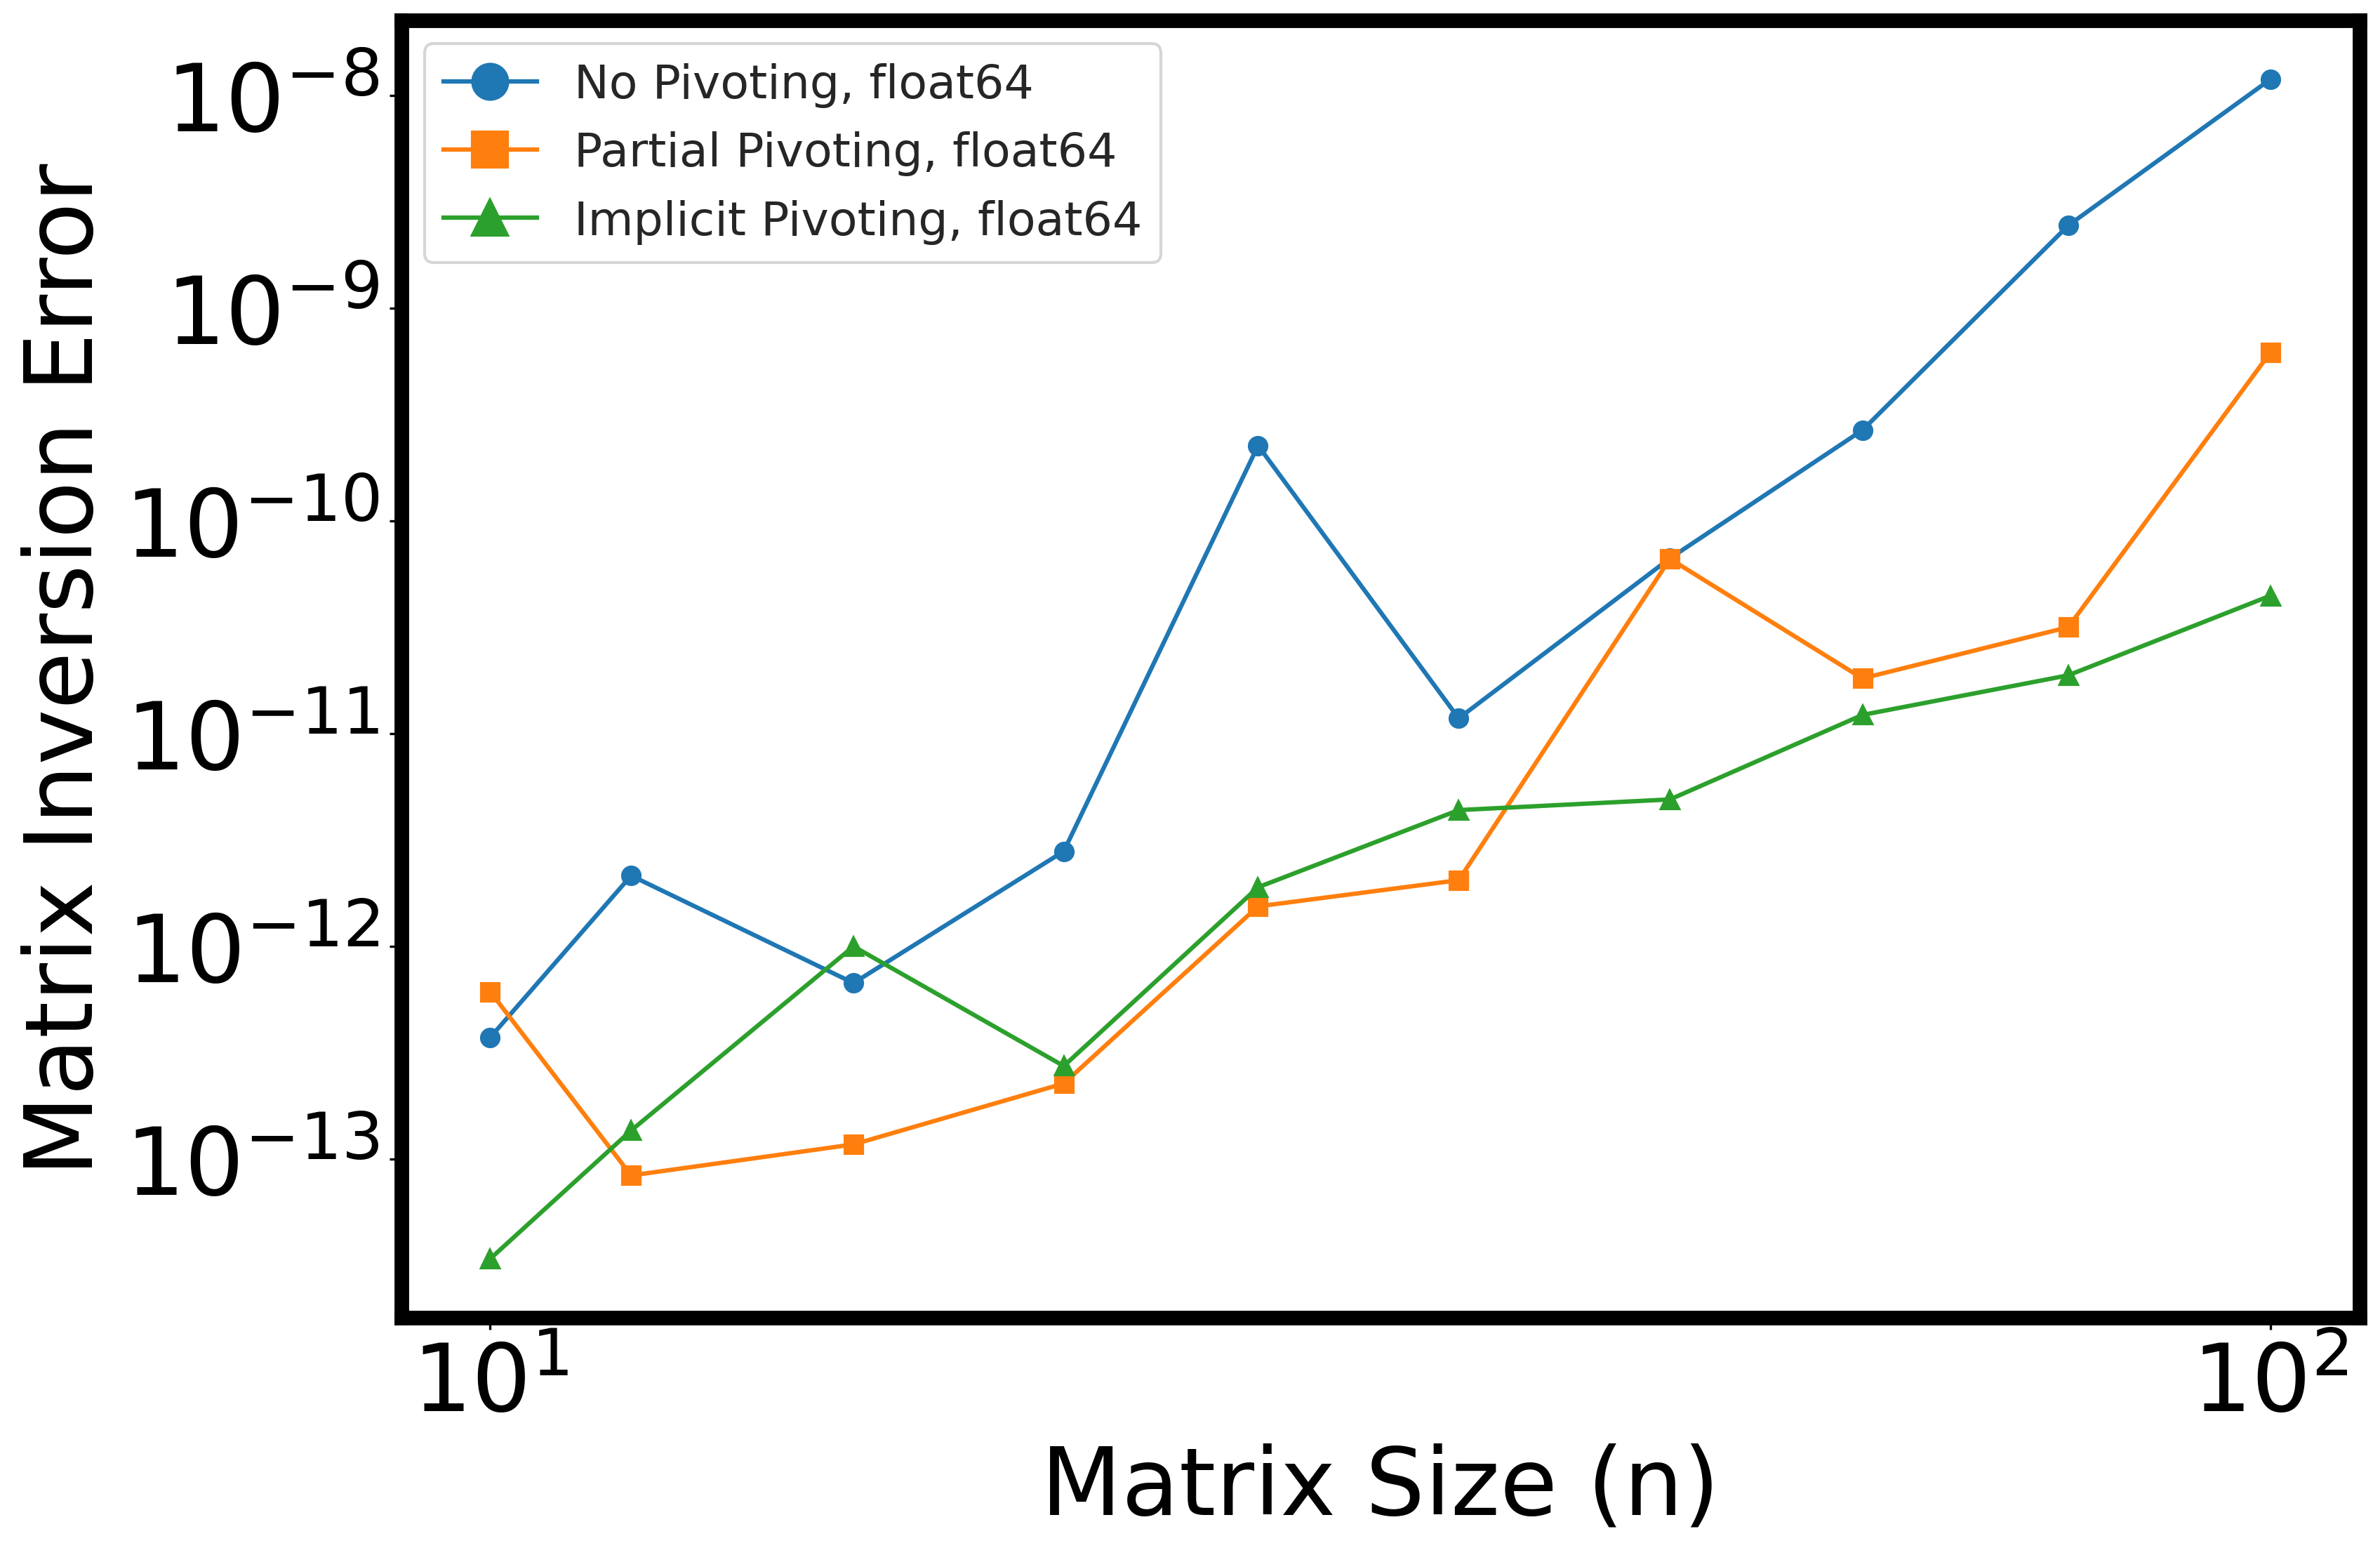

In [ ]:
# plot results 64

plt.plot(bench_noPivot64[:,0], bench_noPivot64[:,1], 'o-', label='No Pivoting, float64')
plt.plot(bench_partialPivot64[:,0], bench_partialPivot64[:,1], 's-', label='Partial Pivoting, float64')
plt.plot(bench_implicitPivot64[:,0], bench_implicitPivot64[:,1], '^-', label='Implicit Pivoting, float64')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Matrix Size (n)')
plt.ylabel('Matrix Inversion Error')
# plt.title('Matrix Inversion Error vs Size')
plt.legend()

# plt.savefig('matrix_inversion_error_comparison.pdf', bbox_inches='tight')

plt.show()

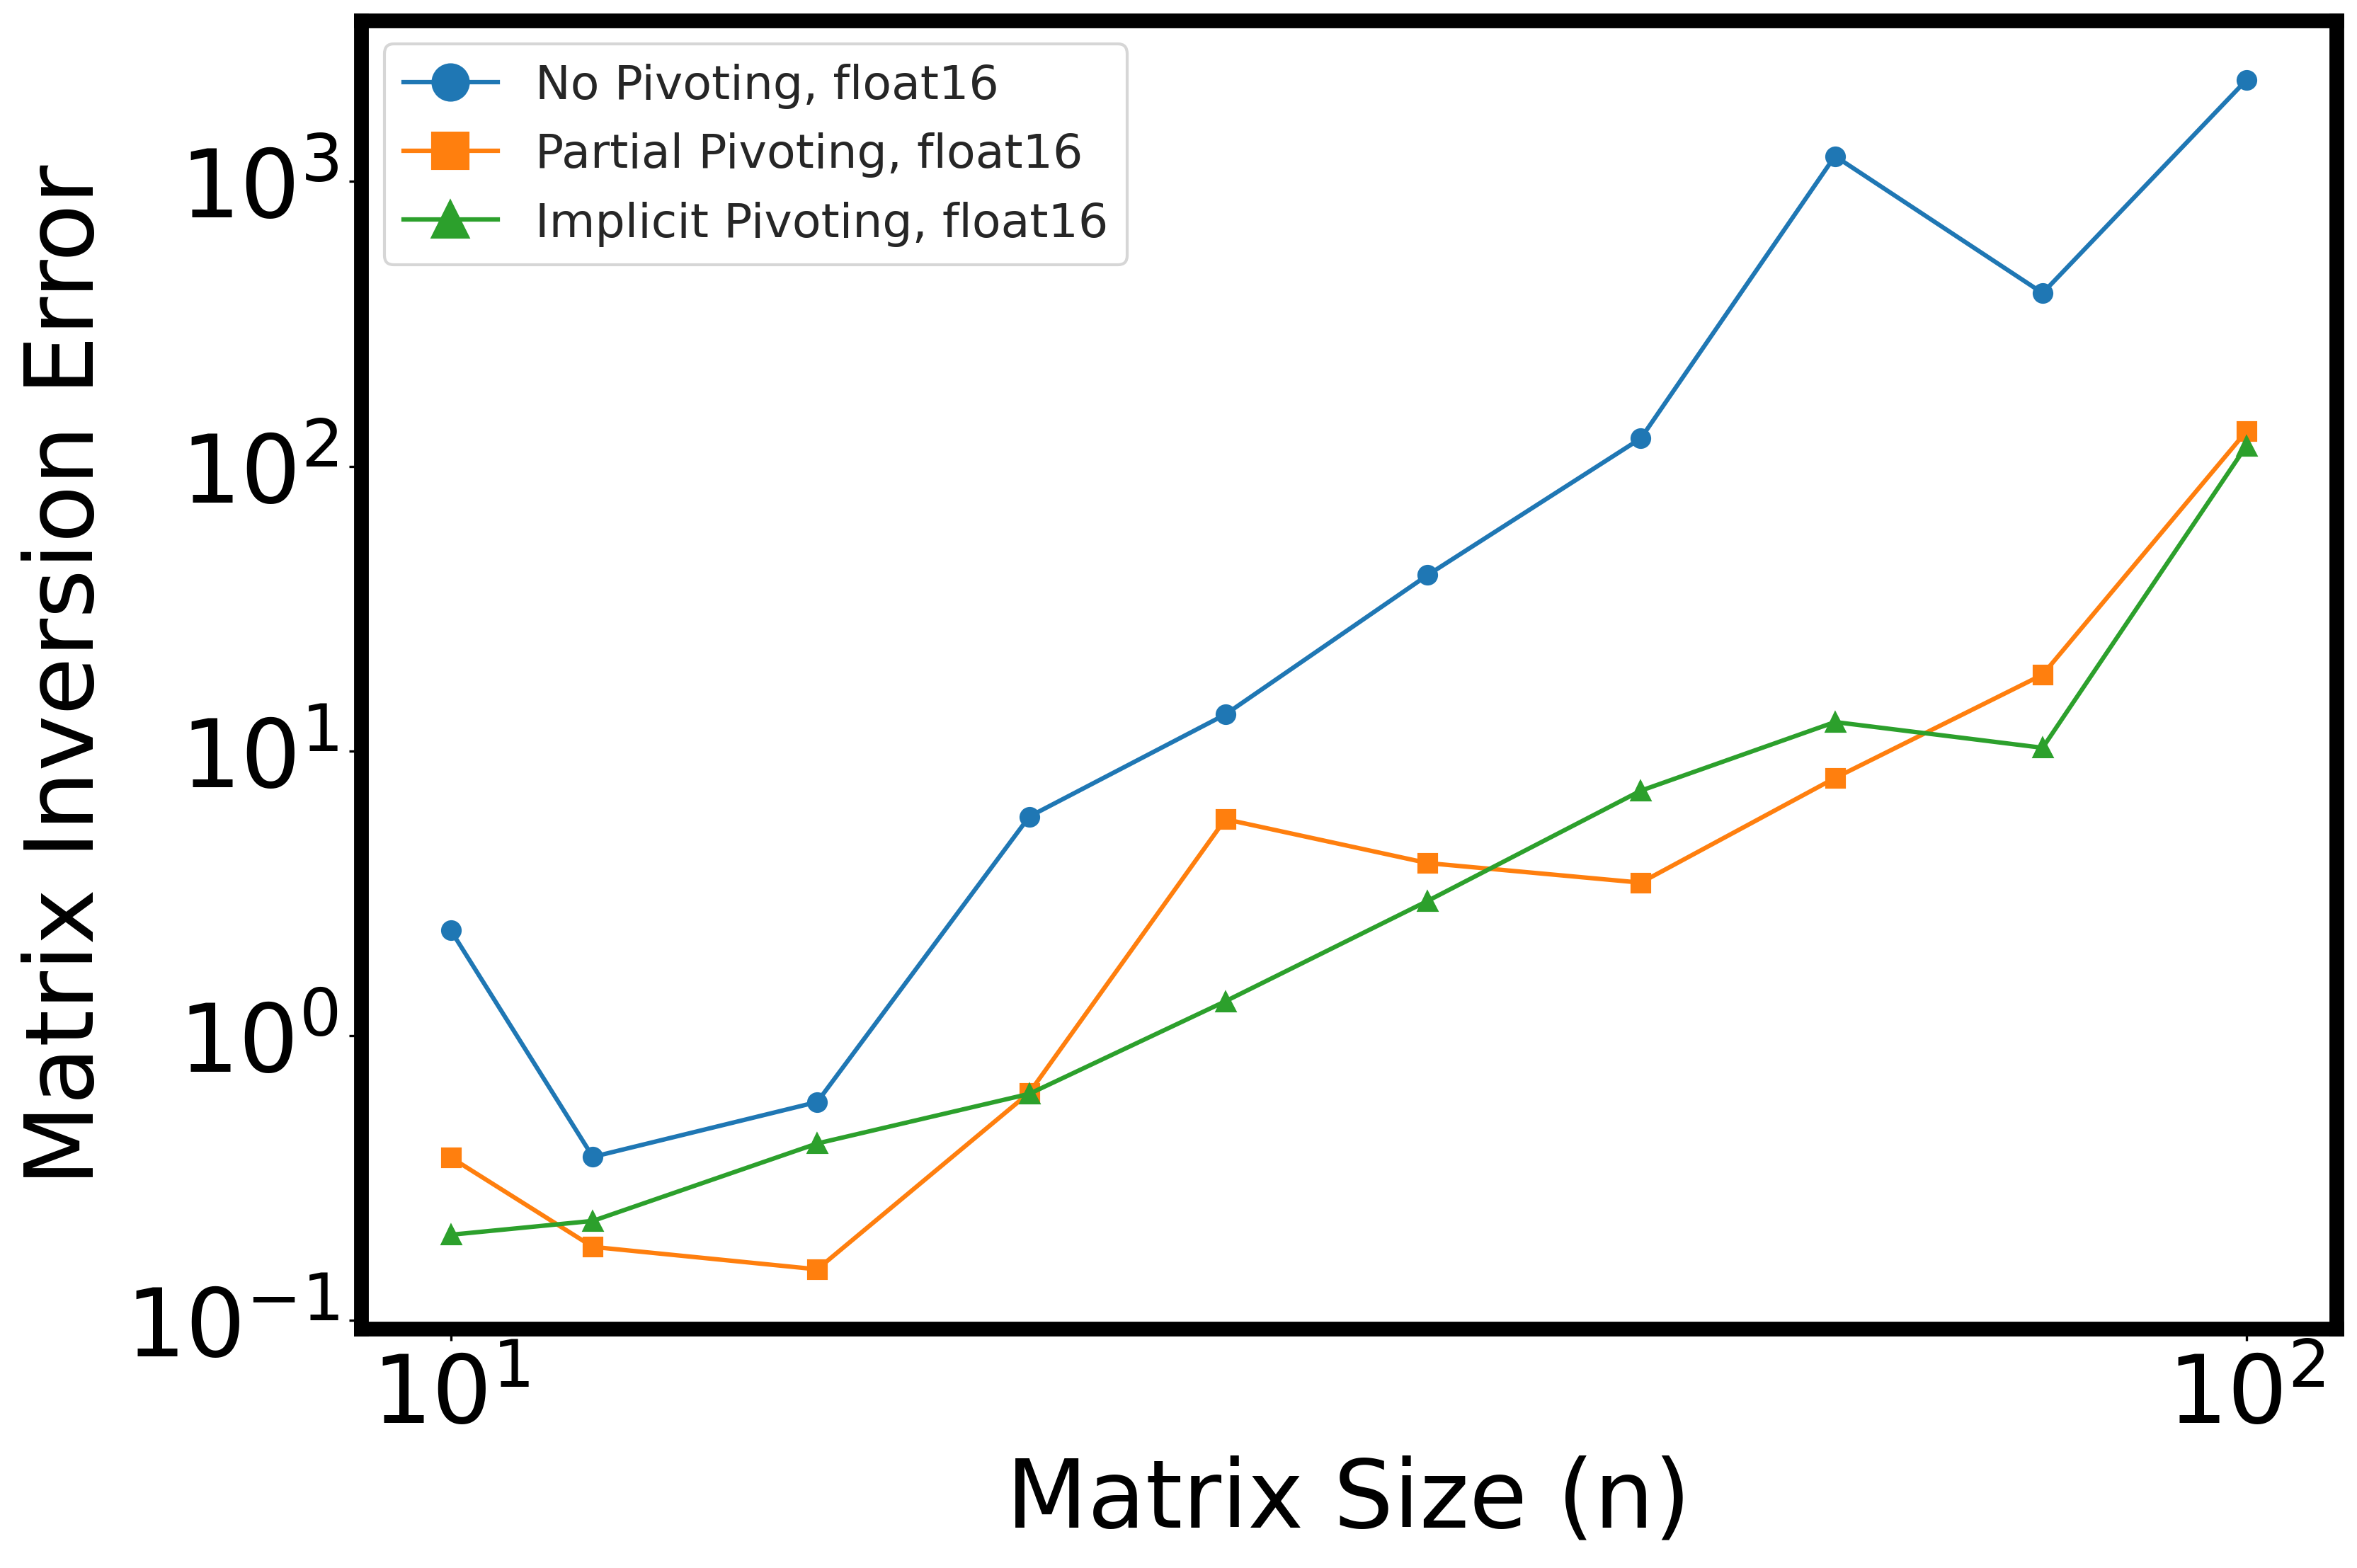

In [ ]:
# plot results 16

plt.plot(bench_noPivot16[:,0], bench_noPivot16[:,1], 'o-', label='No Pivoting, float16')
plt.plot(bench_partialPivot16[:,0], bench_partialPivot16[:,1], 's-', label='Partial Pivoting, float16')
plt.plot(bench_implicitPivot16[:,0], bench_implicitPivot16[:,1], '^-', label='Implicit Pivoting, float16')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Matrix Size (n)')
plt.ylabel('Matrix Inversion Error')
# plt.title('Matrix Inversion Error vs Size')
plt.legend()

# plt.savefig('matrix_inversion_error_comparison.pdf', bbox_inches='tight')

plt.show()

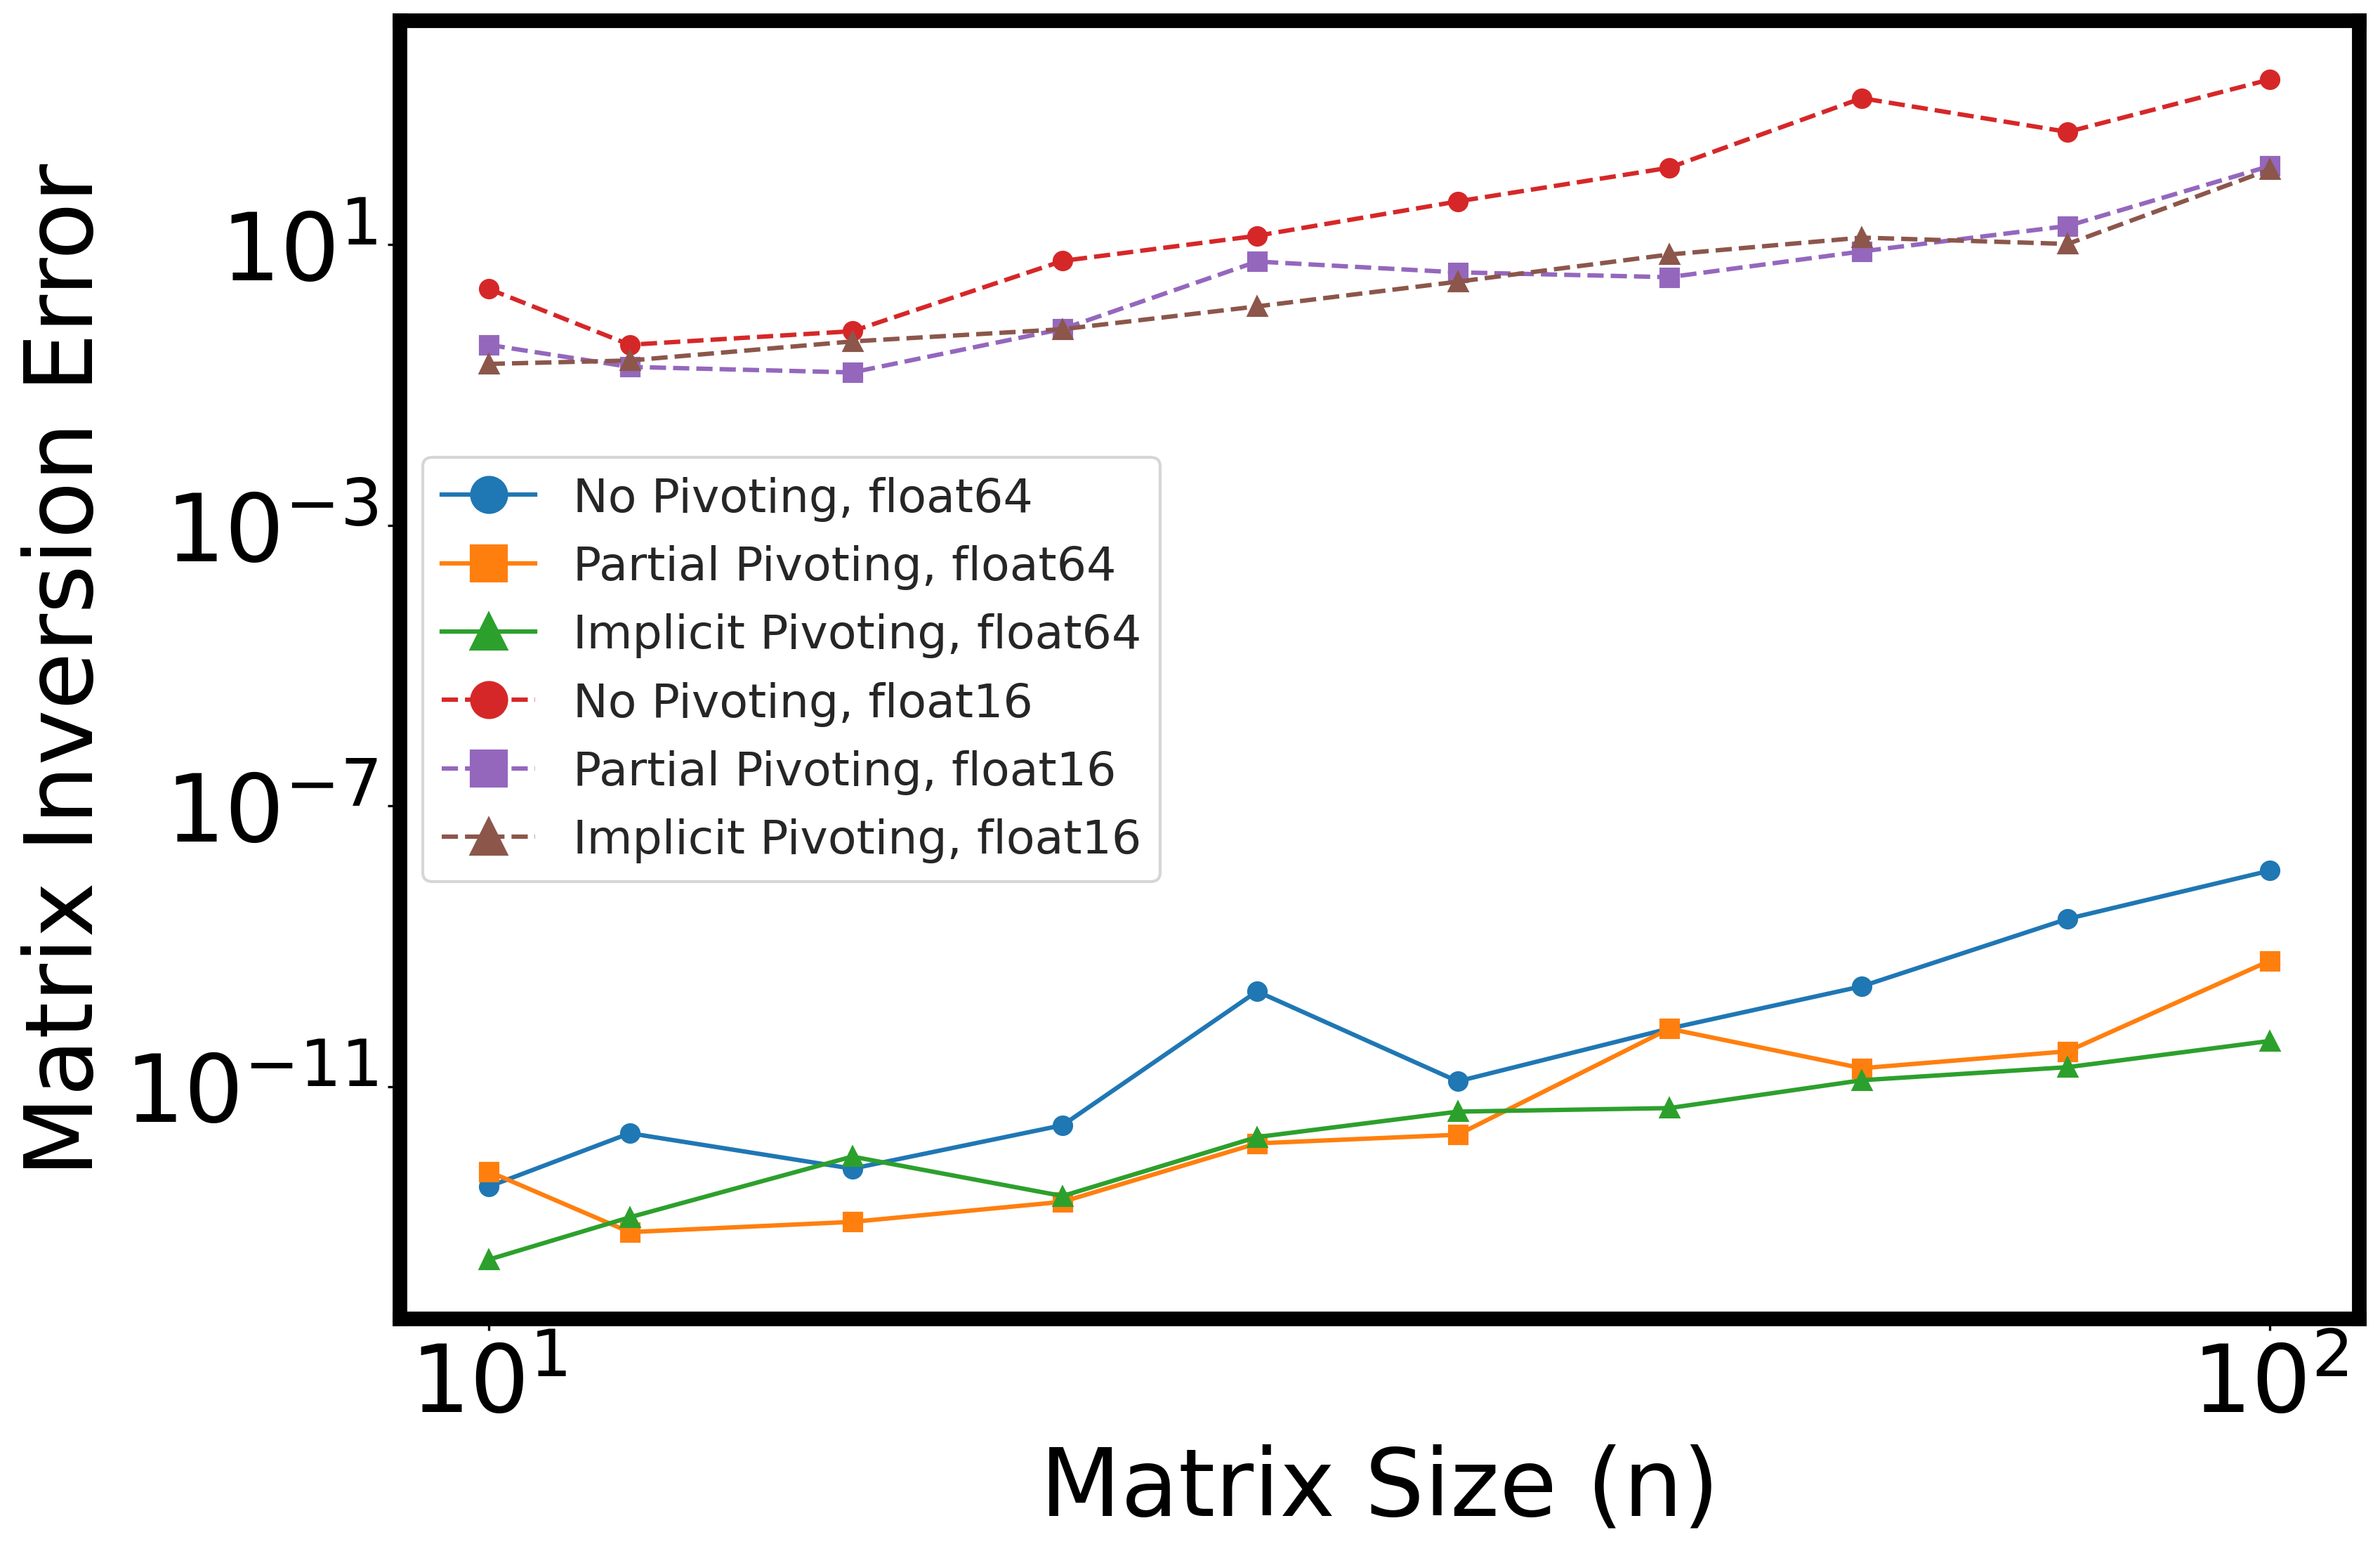

In [ ]:
plt.plot(bench_noPivot64[:,0], bench_noPivot64[:,1], 'o-', label='No Pivoting, float64')
plt.plot(bench_partialPivot64[:,0], bench_partialPivot64[:,1], 's-', label='Partial Pivoting, float64')
plt.plot(bench_implicitPivot64[:,0], bench_implicitPivot64[:,1], '^-', label='Implicit Pivoting, float64')

plt.plot(bench_noPivot16[:,0], bench_noPivot16[:,1], 'o--', label='No Pivoting, float16')
plt.plot(bench_partialPivot16[:,0], bench_partialPivot16[:,1], 's--', label='Partial Pivoting, float16')
plt.plot(bench_implicitPivot16[:,0], bench_implicitPivot16[:,1], '^--', label='Implicit Pivoting, float16')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Matrix Size (n)')
plt.ylabel('Matrix Inversion Error')
# plt.title('Matrix Inversion Error vs Size')
plt.legend()

# plt.savefig('matrix_inversion_error_comparison.pdf', bbox_inches='tight')

plt.show()

Part B:
------
We will now break the LU decomposition algorithm using the Hilbert matrix, which is implemented in the function scipy.linalg.hilbert. The following section implements a corresponding function that performs analogous experiment that corresponds to Part A. We also want to check, if our algorithm will warn us if he expects to perform poorly. Look at the definition of the hilbert matrix in the script. Do you expect that pivoting makes a difference? Explain.

Rember to put all plots into the same canva in order to confront several algorithms.
Your task:
----------
* Generate random matrices of varying size (3 - 50 is already enough) 
* Apply the LU decomposition with and without pivoting and compare their error

In [ ]:
def get_bench_hilbert(fp_type, n_size, pivotMethod=partialPivoting):
    """Benchmark algorithm for a certain floating
    point precision.
    
    Parameters:
    -----------
    n_size: array of floates, specifies the array sizes on which 
            to calculate the matrix error
    fp_type: object of np.dtype, specifies the floating point
             precision (possible are float16, float32, float64)
    pivotMethod: function
    
    Returns:
    --------
    bench_inv: numpy array, array with column entries:
               matrix_size, error, execution_time
    """

    bench_inv = np.zeros((len(n_size), 3))
    for idx, el in enumerate(n_size):
        err = get_mat_err(np.array(hilbert(el), fp_type), pivotMethod=pivotMethod)
        bench_inv[idx, 0] = el
        bench_inv[idx, 1:3] = err
    
    return bench_inv

In [ ]:
    
    #Plots on the same canva: 
    # 16 bit no pivoting, 16 bit partial pivoting, 16 bit implicit pivoting,
    # 64 bit no pivoting, 64 bit partial pivoting, 64 bit implicit pivoting,

    ######################################
    ###########IMPLEMENT HERE!!!!#########
    ######################################

Exercise 5/6: Tridiagonal Matrices and the Thomas/Progronki method
-----------------------------------------------------------------
In the solution of elliptical differential equations, Schroedinger equations or during spline interpolation one has to solve systems of equations with a trigonal coefficient matrices. Instead of using the LU decomposition one can then use the Thomas algorithm, which is a variation of the Gauss algorithm for this kind of matrices. 
A trigonal matrix is defined as
$\mathbf{T} = \begin{pmatrix} d_1  & -e_1 & 0 & \dots     & 0 \\
                  -c_2 & d_2 & -e_2 & \dots &  0 \\
                  \dots & \dots & \dots & \dots & 0 \\
                  0 & \dots & -c_{n-1} & d_{n-1} & -e_{n-1} \\
                  0 & \dots & \dots & -c_n & d_n \end{pmatrix}$
and your task is to find a solution to the trigonal system of equations
$\mathbf{T} \vec{x} = \vec{b}$. 
Using the notation in this notebook, which is choosen for consistency with the literature on the solution of boundary problems of partial differential equations, we can formulate the Thomas algorithm as follows. I start with 1 as the first element in an array. Note that python starts with 0.
$\alpha_1 = \frac{e_1}{d_1} \ \ \beta_1 = \frac{b_1}{d_1}$,
$\alpha_i = \frac{e_i}{d_i - c_i \alpha_{i-1}} \ \ (i = 2, \dots, n-1)$ and 
$\beta_i = \frac{b_i + c_i \beta_{i-1}}{d_i - c_i \alpha_{i-1}} \ \ (i = 2, \dots,n )$
and finally
$x_i = \alpha_i x_{i+1} + \beta_i \ \ (i = 1, \dots, n-1), \ \ x_n = \beta_n$. 

Your task is to implement this algorithm in the next section and compare with the trigonal system defined in the script.

Your task:
----------
* Manually solve (put that into the report) the following system of equations $\begin{pmatrix} 2 & 1 & 0 & 0 & 0 \\ 1 & 2 & 1 & 0 & 0 \\ 0 & 1 & 2 & 1 & 0 \\ 0 & 0 & 1 & 2 & 1 \\ 0 & 0 & 0 & 1 & 2 \end{pmatrix} \begin{pmatrix} x_1 \\ x_2 \\ x_3 \\ x_4 \\ x_5 \end{pmatrix} = \begin{pmatrix} 1 \\ 2 \\ 3 \\ 4 \\ 5 \end{pmatrix}$ 
by applying the thomas/progronki method. 
* Write a function to implement the Thomas/Progronki method in the following section.
* Compare the result you obtained manually with the output from your function.

In [251]:
#this will be left blank in the students version
def thomas(c, d, e, b):
    """ Thomas algorithm to solve the trigonal system of equations. 
    
    Parameters:
    -----------
    c: numpy array, lower diagonal element of the trigonal matrix
    d: numpy array, diagonal element of the trigonal matrix
    e: numpy array, upper diagonal element of the trigonal matrix
    b: numpy array, right hand side of the system of equations
    
    Returns:
    --------
    x: numpy array, solution to the trigonal system of equations
    """
    #prefactor convention
    e = -e 
    c = -c
    n = len(d)
    
    #########Implemented code###############
    x=np.zeros(n)
    alpha=np.zeros(n-1)#alpha vector
    beta=np.zeros(n)#beta vector
    alpha[0]=e[0]/d[0]#first alpha term
    beta[0]=b[0]/d[0]#first beta term
    for i in range(1, n-1):
        alpha[i] = e[i] / (d[i] - c[i]*alpha[i-1])

    for i in range(1, n):
    
        beta[i] = (b[i] - c[i-1]*beta[i-1])/(d[i] - c[i-1]*alpha[i-1])
        
    #Back substitution
    x[-1] = beta[-1]
    for i in range(n-2, -1, -1):
        x[i] = beta[i] - alpha[i]*x[i+1]
    return x

In [252]:
#test your routine using the matrix provided in the script
A = np.array([ #provided matrix 
    [2, 1, 0, 0, 0],
    [1, 2, 1, 0, 0],
    [0, 1, 2, 1, 0],
    [0, 0, 1, 2, 1],
    [0, 0, 0, 1, 2]])
n=A.shape[0] #dimension of A
b=np.arange(n)+1 #right-hand side of the equation

#Diagonal terms of the matrix
c=-np.array([A[i,j] for i in range(n) for j in range(n) if i==j+1])
d=np.array([A[i,j] for i in range(n) for j in range(n) if i==j]) 
e=-np.array([A[i,j] for i in range(n) for j in range(n) if i==j-1])
sol=thomas(c, d, e, b)
print("The solution is: \n",sol)
print(sympy.latex(sympy.Matrix(sol)))
    

The solution is: 
 [5.00000000e-01 2.22044605e-16 1.50000000e+00 0.00000000e+00
 2.50000000e+00]
\left[\begin{matrix}0.5\\2.22044604925031 \cdot 10^{-16}\\1.5\\0.0\\2.5\end{matrix}\right]


Check about the correctness of the solution

In [253]:
A = np.array([
    [2, 1, 0, 0, 0],
    [1, 2, 1, 0, 0],
    [0, 1, 2, 1, 0],
    [0, 0, 1, 2, 1],
    [0, 0, 0, 1, 2]
])
b=np.array([1,2,3,4,5])
print(LA.solve(A,b))

[ 5.00000000e-01  1.48029737e-16  1.50000000e+00 -8.88178420e-17
  2.50000000e+00]


We can check if the algorithm scales O(N).

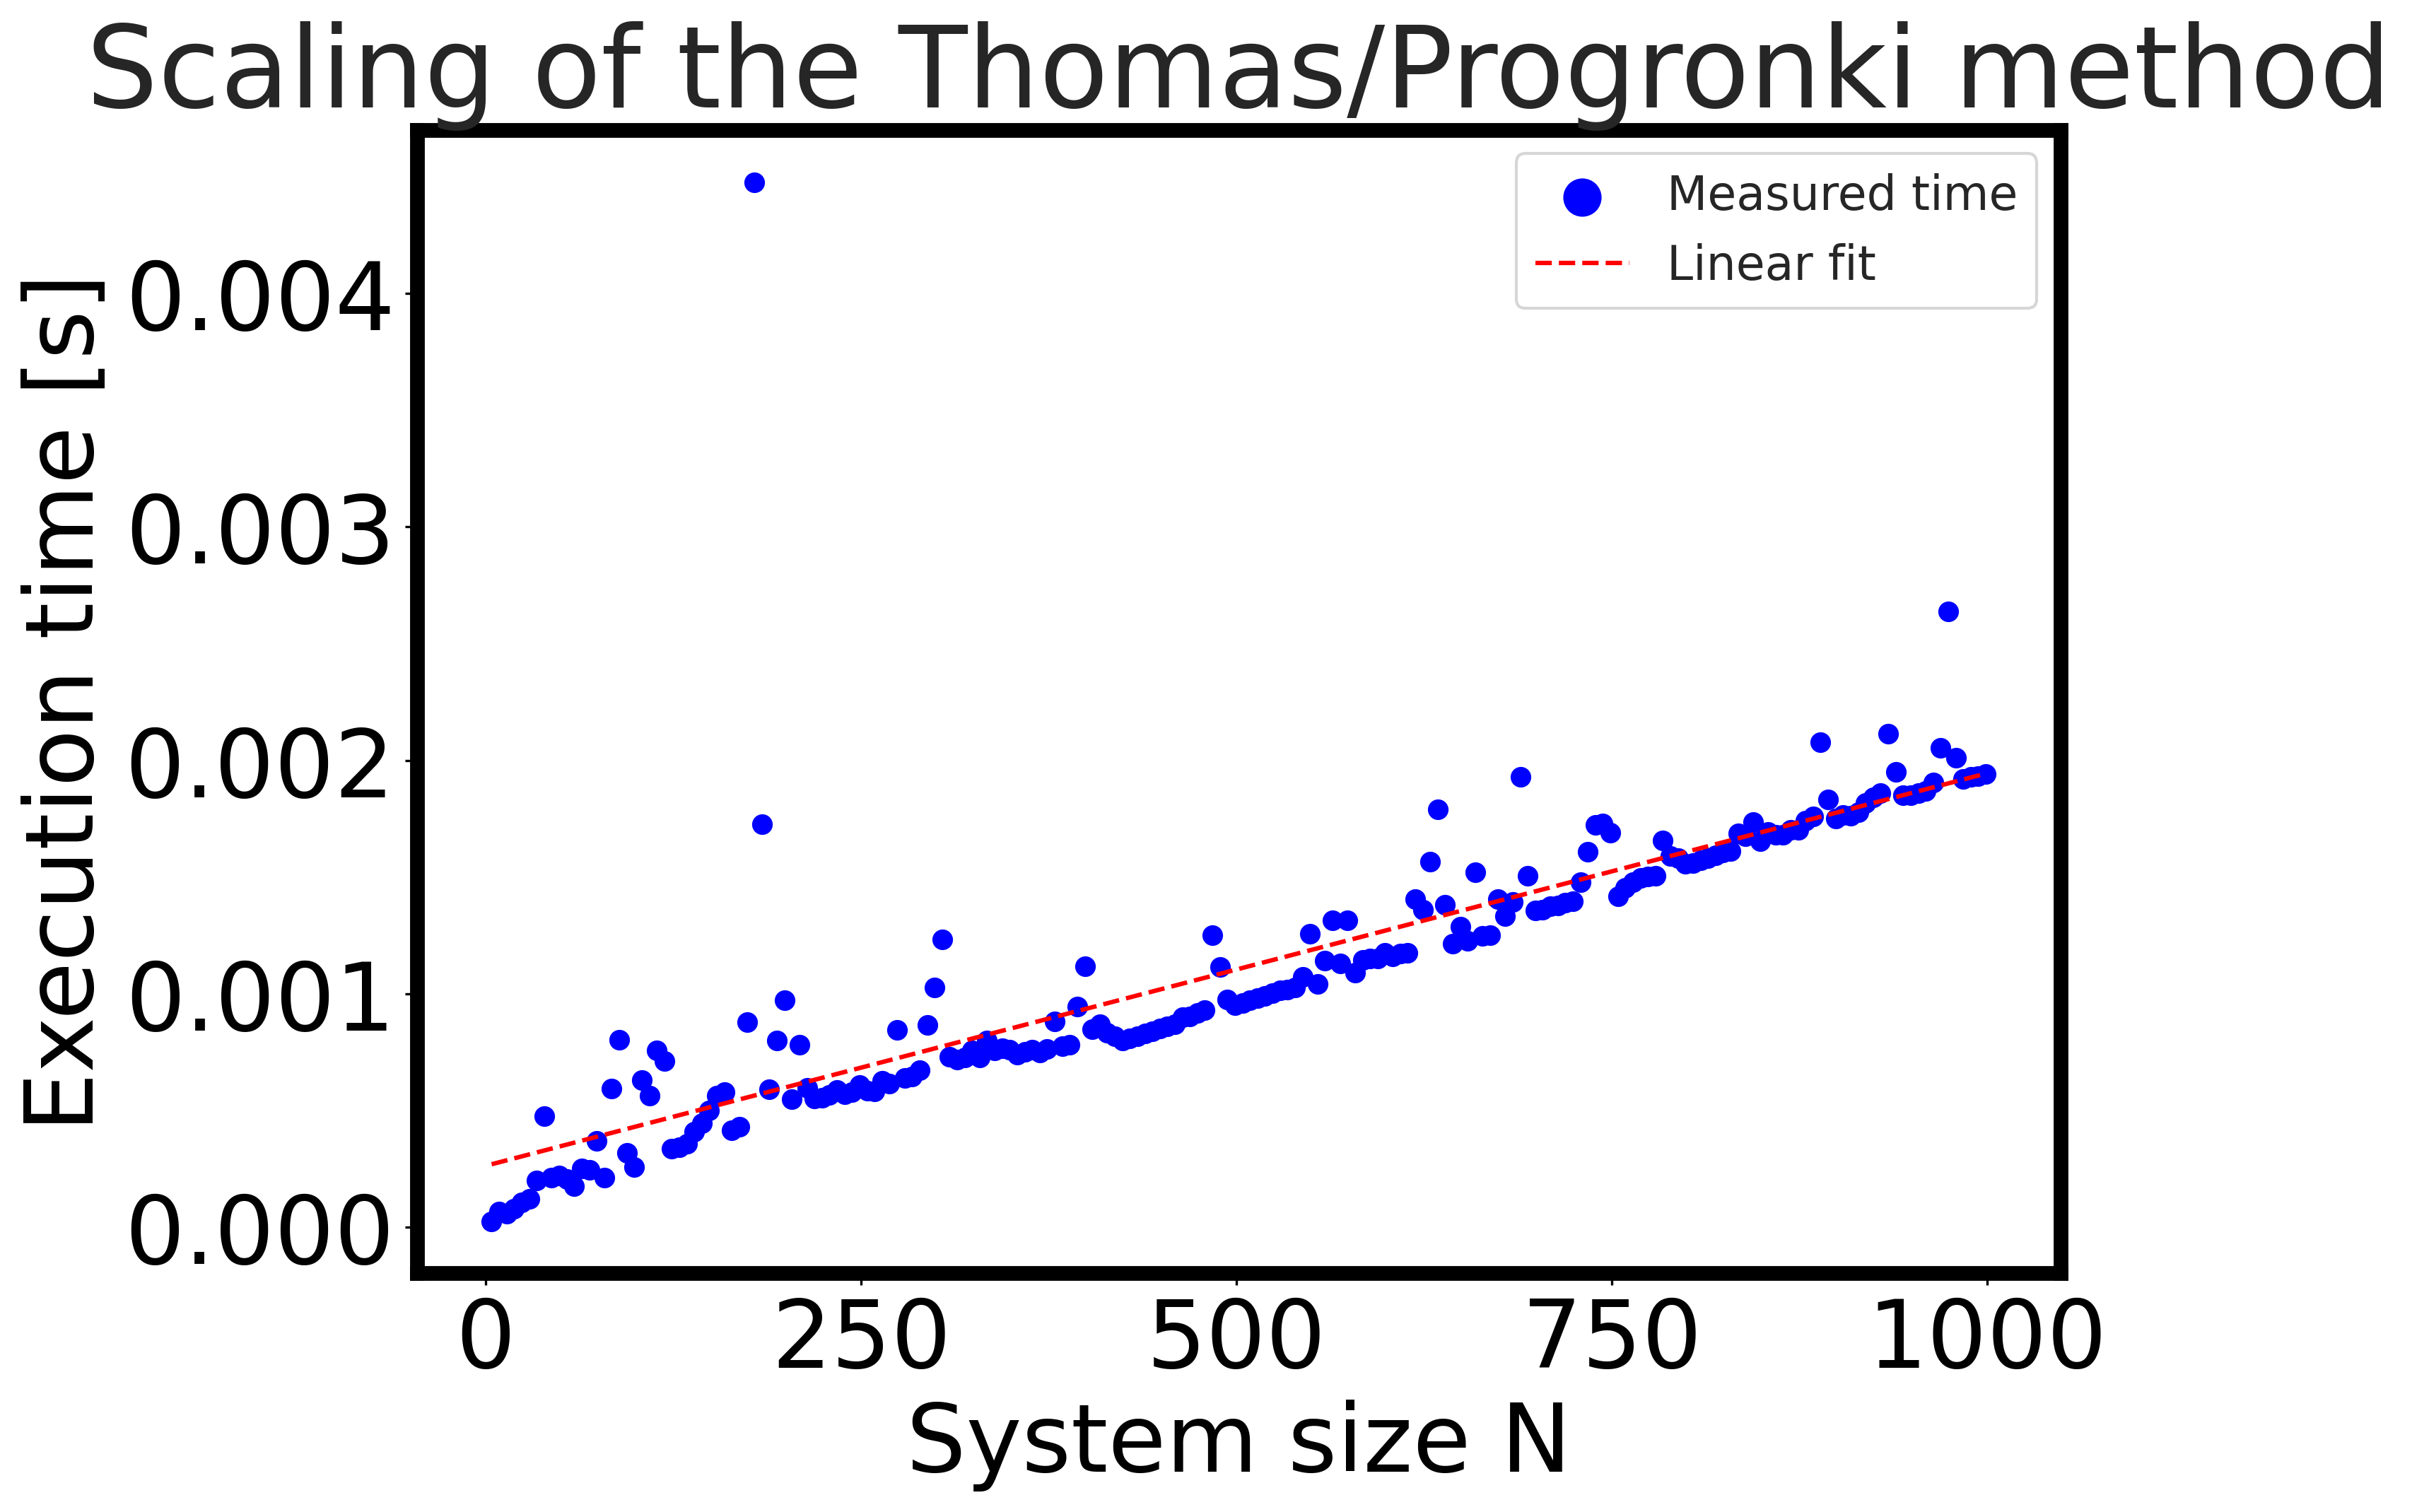

In [ ]:
Ns = np.arange(4, 1004, 5)#Selected test range 
timings = np.zeros(len(Ns))#time vector

#Loop to get the execution time vector
for i, n in enumerate(Ns):
    c = np.random.random(n-1)*100
    d = np.random.random(n)*100
    e = np.random.random(n-1)*100
    b = np.random.random(n)*100
    start_time = time.time()
    x = thomas(-c, d, -e, b);
    end_time = time.time()
    timings[i] = end_time - start_time

#Plotting the result
fig, ax = plt.subplots(figsize=(10,7))
ax.scatter(Ns, timings, marker='o', color='b', label='Measured time')

#Linear fit 
fit = np.polyfit(Ns, timings, 1)
ax.plot(Ns, np.polyval(fit, Ns), 'r--', label=f'Linear fit')
ax.set_xlabel("System size N")
ax.set_ylabel("Execution time [s]")
ax.set_title("Scaling of the Thomas/Progronki method")
ax.legend()
plt.show()

Exercise 7: Line ratios of O II/III
---------------------------------------------------
The atomic data for O II/III are given in the appendix of the manual.  Here they are used to set up the rate equations which are then solved for a range of densities and temperatures using the standard routines.  The solutions are then
used to determine theoretical line intensity ratios which could be compared with observations to determine temperatures and densities of planetary and other low density nebulae.  Although the abundances cancel in the ratios they can be determined by looking at the strengths of individual li

Your task:
----------
* Use the routines provided for a number of temperatures (O II) and densities (O III) to produce line ratios and plot them.
* Comment on your results.

In [ ]:
###  Define the model O II atom. Compare these numbers with those given in the Appendix.
###  Number of levels, a label, statistical weight and energy (in cm^{-1})
nlev_oii=5
lab_oii=np.char.array(["4S3_2","2D5_2","2D3_2","2P3_2","2P1_2"])
weight_oii=np.array([4,6,4,4,2])
energy_oii=np.array([0.0,26810.55,26830.57,40468.01,40470.00])
### With n levels there are n*(n-1)/2 possible transitions.
###  Upsilon is dimensionless while A has dimension sec^{-1}.
ups_oii=np.array([[0.,0.8,0.54,0.27,0.13],
             [0.,0.,1.17,0.73,0.3],
             [0.,0.,0.,0.41,0.28],
             [0.,0.,0.,0.,0.29]])
aij_oii=np.array([[0.,3.6e-5,1.8e-4,5.8e-2,2.4e-2],
              [0.,0.,1.3e-7,0.11,5.6e-2],
              [0.,0.,0.,5.8e-2,9.4e-2],
              [0.,0.,0.,0.,1.4e-10]])


In [ ]:
###  Define the model O III atom.  Again, check these numbers with those listed in the Appendix
###  Number of levels, a label, statistical weight and energy (in cm^{-1})
nlev_oiii=5
lab_oiii=np.char.array(["3P0","3P1","3P2","1D2","1S0"])
weight_oiii=np.array([1,3,5,5,1])
energy_oiii=np.array([0.0,113.178,306.174,20273.27,43185.74])
### With n levels there are n*(n-1)/2 possible transitions.
###  Upsilon is dimensionless while A has dimension sec^{-1}.
ups_oiii=np.array([[0.,0.54,0.27,0.24,0.03],
             [0.,0.,1.29,0.72,0.09],
             [0.,0.,0.,1.21,0.16],
             [0.,0.,0.,0.,0.62]])
aij_oiii=np.array([[0.,2.6e-5,3.0e-11,2.7e-6,0.0],
              [0.,0.,9.8e-5,6.7e-3,0.22],
              [0.,0.,0.,2.0e-2,7.8e-4],
              [0.,0.,0.,0.,1.8]])



In [ ]:
def setup_rates(n,weight,energy,ups,aij,ne,t,a,b):
### the ratio of the planck constant to the boltzmann constant times the speed of light
###  the latter appears to convert the energies from cm^{-1}
###  Compare the code with the equations given in the manual.
###  Note that in the presence of a radiational field additional terms appear.  
###  These apply in the optically thin case.
    hck=1.438835e0
    tnfac=8.631e-6*ne/np.sqrt(t)
    hckt=hck/t
    for i in np.arange(n-1):
        for j in np.arange(i+1,n):
            cji=tnfac/weight[j]*ups[i,j]
            cij=cji*weight[j]/weight[i]*np.exp(-hckt*(energy[j]-energy[i]))
            a[i,j]=a[i,j]-cji-aij[i,j]
            a[j,i]=a[j,i]-cij
            a[i,i]=a[i,i]+cij
            a[j,j]=a[j,j]+cji+aij[i,j]
    a[n-1,0:n-1]=1.0e0
    b[n-1]=1.e0
    return a,b

In [ ]:
NDEN=15
### Calculate the line ratio for O II and plot it as a function of density (or log denisty).  
### Do this for a few temperatures in the range 5000-40000K.  
### All the plots should appear in the same graph. 
### Discuss your results.
t=5000.e0
line_ratio=np.zeros(NDEN)
deltn=np.emath.log10(2.e0)
logne=np.linspace(deltn,NDEN*deltn,NDEN).tolist()
for i in range(NDEN):
    a=np.zeros((nlev_oii,nlev_oii))
    b=np.zeros(nlev_oii)
    ne=10.e0**logne[i]
    setup_rates(nlev_oii,weight_oii,energy_oii,ups_oii,aij_oii,ne,t,a,b)
    b=solve_eq(a,b)
###  The line ratio corresponds to the diagram given in the text.  
###  Here we compare the number of transitions in the 1-2 line with the number in the 1-3 line.     
    line_ratio[i]=b[1]*aij_oii[0,1]/(b[2]*aij_oii[0,2])
###  print(logne[i],line_ratio[i])

IndexError: arrays used as indices must be of integer (or boolean) type

In [ ]:
NTEMP=15
### Calculate the line ratio for O III and plot it as a function of temperature (or log temperature)
### Do this for a few densities in the range of 10. to 10^6 cm^{-3}
### Plot all these on the same graph
###  Discuss your findings.
ne=10.
line_ratio=np.zeros(NTEMP)
temp=np.zeros(NTEMP)
for i in range(NTEMP):
    temp[i]=6000.+i*1000.
for i in range(NTEMP):
    a=np.zeros((nlev_oiii,nlev_oiii))
    b=np.zeros(nlev_oiii)
    t=temp[i]
    setup_rates(nlev_oiii,weight_oiii,energy_oiii,ups_oiii,aij_oiii,ne,t,a,b)
    b=solve_eq(a,b)
    line_ratio[i]=b[3]*(aij_oiii[2,3]+aij_oiii[1,3])/(b[4]*aij_oiii[3,4])
###    print(temp[i],line_ratio[i])

Advanced Task 1: Iterative improvement of the solution
---------------------------------------------------
As you saw in the previous sections, it can be quite challenging to control the increase in roundoff error especially for large matrices. This can even lead to matrices becoming singular. As explained in the script, we can iteratively refine the matrix inverse, exhausting the available machine precision. Please refer to the script for details on the implementation. Your task now is to write a little wrapper around your matrix inversion algorithm such that it adds the functionality of iterative refinement.

Your task:
----------
* Implement the method of iterative improvement in the following section.
* Test your implementation

In [ ]:
    ######################################
    ###########IMPLEMENT HERE!!!!#########
    ######################################

Advanced Task 2:  S II/III
---------------------------------------------------
The atomic structures of S II and S III are similar to those of O II and O III but the numerical values are different so
that the line ratios will also have a similar form but different numbers.  Such differences can give access to other temperature and density ranges and can, of course, also provide information about sulphur abundances in PN and other nebulae.   

Your task:
----------
* Replace the data for exercise 7 with those for S II/III given in the appendix of the manual.
* Compare the plots for O II/III with those for S II/III and comment on anything you notice.